In [17]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler
import pandas as pd
import random
import numpy as np
import timeit
from gorlib import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [18]:
#load data
dfs = load_file("./data.xlsx")
print(dfs.keys())
for key in dfs:
    if "Date" in dfs[key].columns:
        dfs[key]['Date'] = pd.to_datetime(dfs[key]['Date'])

dict_keys(['Forecasted Consumption', 'Meter List', 'Rates'])


## Results 

In [19]:
res = calc_costs(dfs['Forecasted Consumption'], dfs['Rates'], dfs['Meter List'], "2020-10-01", "2022-09-30")
print(res)

     Meter ID  Total Estimated Consumption (kWh)  Total Cost (Pounds)
0  1000000603                           24656.07                 8.26
1    10588707                          122376.66                28.48
2    10626610                          303294.62                88.16


In [20]:
randmeters = gen_rand_meters(dfs['Rates'], mcnt=100)
randconsm  = gen_mock_consn(randmeters["Meter ID"].tolist(),"2020-10-01", "2022-09-30")

In [21]:
res = calc_costs(randconsm, dfs['Rates'],randmeters, "2020-10-01", "2022-09-30")
print(res.head(10))

   Meter ID  Total Estimated Consumption (kWh)  Total Cost (Pounds)
0      1003                          110001.39                25.82
1      1010                          106830.19                25.08
2      1098                          109816.52                31.80
3      1057                          109595.26                32.89
4      1095                          108816.03                32.60
5      1019                          110825.89                32.38
6      1070                          109516.66                25.70
7      1012                          112343.01                32.81
8      1052                          110348.79                37.15
9      1061                          113441.81                34.05


# Profiling

In [33]:
randmeters = gen_rand_meters(dfs['Rates'], mcnt=100)
randconsm  = gen_mock_consn(randmeters["Meter ID"].tolist(),"2020-10-01", "2022-09-30")
permtr_cnt = randconsm.shape[0]/100.0

In [23]:
%%timeit
res = calc_costs(randconsm, dfs['Rates'],randmeters, "2020-10-01", "2022-09-30")

1 loop, best of 5: 721 ms per loop


In [24]:
randmeters = gen_rand_meters(dfs['Rates'], mcnt=1000)
randconsm  = gen_mock_consn(randmeters["Meter ID"].tolist(),"2020-10-01", "2022-09-30")

In [25]:
%%timeit
res = calc_costs(randconsm, dfs['Rates'],randmeters, "2020-10-01", "2022-09-30")

1 loop, best of 5: 11.3 s per loop


In [26]:
imports = '''
from gorlib import calc_costs, gen_rand_meters, gen_mock_consn, load_file
import pandas as pd
dfs = load_file("./data.xlsx")
for key in dfs:
    if "Date" in dfs[key].columns:
        dfs[key]['Date'] = pd.to_datetime(dfs[key]['Date'])
randmeters = gen_rand_meters(dfs['Rates'], mcnt={mcnt})
randconsm  = gen_mock_consn(randmeters["Meter ID"].tolist(),"2020-10-01", "2022-09-30")
'''
testcode= '''
calc_costs(randconsm, dfs['Rates'],randmeters, "2020-10-01", "2022-09-30")
'''

cntlist = [10,50,100,500,1000,2000]
pftime = [timeit.timeit(stmt=testcode, setup=imports.format(mcnt=cnt), number=10)/10.0 for cnt in cntlist]

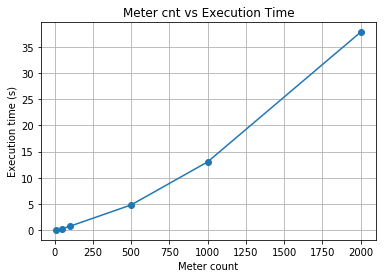

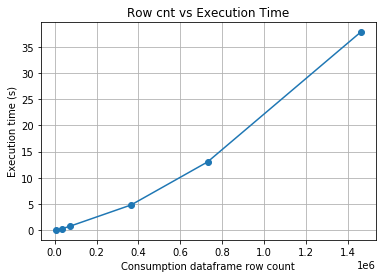

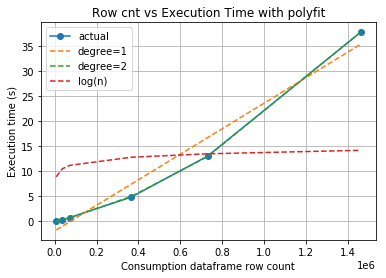

In [46]:
import matplotlib.pyplot as plt
import numpy.polynomial.polynomial as poly
plt.figure()
plt.plot(cntlist,pftime, marker="o")
plt.xlabel("Meter count")
plt.ylabel("Execution time (s)")
plt.title("Meter cnt vs Execution Time")
plt.grid()

plt.figure()
plt.plot(np.array(cntlist)*permtr_cnt,pftime, marker="o")
plt.xlabel("Consumption dataframe row count")
plt.ylabel("Execution time (s)")
plt.title("Row cnt vs Execution Time")
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.grid()

plt.figure()
rcnt = np.array(cntlist)*permtr_cnt
plt.plot(rcnt,pftime, marker="o", label="actual")
p1coefs = poly.polyfit(rcnt, pftime, 1)
ffit = poly.polyval(rcnt, p1coefs)
plt.plot(rcnt, ffit,"--", label="degree=1")
p2coefs = poly.polyfit(rcnt, pftime, 2)
ffit = poly.polyval(rcnt, p2coefs)
plt.plot(rcnt, ffit,"--", label="degree=2")
plt.plot(rcnt, np.log(rcnt),"--", label="log(n)")
plt.legend()
plt.xlabel("Consumption dataframe row count")
plt.ylabel("Execution time (s)")
plt.title("Row cnt vs Execution Time with polyfit")
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.grid()
plt.show()
plt.show()

In [28]:
%lprun -f calc_meter_cost calc_costs(randconsm, dfs['Rates'], randmeters, "2020-10-01", "2022-09-30")

Timer unit: 1e-06 s

Total time: 19.8885 s
File: /home/radhika/gorlib.py
Function: calc_meter_cost at line 19

Line #      Hits         Time  Per Hit   % Time  Line Contents
    19                                           def calc_meter_cost(forecast, rates, mid, ezone, aq, sdate, edate):
    20                                               """
    21                                               """
    22      1000    7473370.0   7473.4     37.6      fdsel = (forecast["Meter ID"]== mid) & (forecast["Date"] >= sdate) & (forecast["Date"] < edate)
    23      1000    1592338.0   1592.3      8.0      rsel = (rates['Exit Zone'] == ezone) & (rates['Annual Quantity (Min)'] <= aq) & (rates['Annual Quantity (Max)'] > aq)
    24      1000     938905.0    938.9      4.7      dff = forecast.loc[fdsel]
    25      1000    1003036.0   1003.0      5.0      dff = dff.set_index('Date')
    26      1000     207977.0    208.0      1.0      dff = dff.sort_index()
    27                                 

In [29]:
%%timeit
res = calc_costs_opt(randconsm, dfs['Rates'], randmeters, "2020-10-01", "2022-09-30")

1 loop, best of 5: 12.8 s per loop


In [30]:
%lprun -f calc_meter_cost_opt calc_costs_opt(randconsm, dfs['Rates'], randmeters, "2020-10-01", "2022-09-30")

Timer unit: 1e-06 s

Total time: 19.166 s
File: /home/radhika/gorlib.py
Function: calc_meter_cost_opt at line 38

Line #      Hits         Time  Per Hit   % Time  Line Contents
    38                                           def calc_meter_cost_opt(forecast, rates, mid, ezone, aq, sdate, edate):
    39                                               """
    40                                               """
    41      1000    7289769.0   7289.8     38.0      fdsel = (forecast["Meter ID"]== mid) & (forecast["Date"] >= sdate) & (forecast["Date"] < edate)
    42      1000    1543282.0   1543.3      8.1      rsel = (rates['Exit Zone'] == ezone) & (rates['Annual Quantity (Min)'] <= aq) & (rates['Annual Quantity (Max)'] > aq)
    43      1000     898802.0    898.8      4.7      dff = forecast.loc[fdsel]
    44      1000     968443.0    968.4      5.1      dff = dff.set_index('Date')
    45      1000     200949.0    200.9      1.0      dff = dff.sort_index()
    46                          